# QA/QC of eye-tracking data

This notebook visualizes ET data for the purpose of QC'ing the BIDS conversion.

In [1]:
%matplotlib inline

from pathlib import Path
import json
import ppjson
from importlib import reload  # For debugging purposes

import numpy as np
import pandas as pd

import eyetrackingrun as et
from matplotlib import pyplot as plt
import plot

In the schedule.tsv file, we've listed the EDF files we created and their associated sessions. Now, let's check out what's in the file.

In [2]:
edf_lookup = pd.read_csv("schedule.tsv", sep='\t', na_values="n/a")
edf_lookup

,session,day,PE,fixation_edf,qct_edf,rest_edf,bht_edf
0,1,2023-10-20,LR,fixation_2023-10-20_18h48.03.561_5_session_1.EDF,qct_2023-10-20_19h40.38.964_2_session_1.EDF,rest_2023-10-20_19h48.22.344_0_session_1.EDF,bht_2023-10-20_20h10.50.517_0_session_1.EDF
1,3,2023-10-21,LR,fixation_2023-10-21_09h26.29.983_3_session_3.EDF,qct_2023-10-21_10h04.32.961_0_session_3.EDF,rest_2023-10-21_10h11.23.092_0_session_3.EDF,bht_2023-10-21_10h33.23.269_0_session_3.EDF
2,4,2023-10-21,RL,fixation_2023-10-21_11h28.03.360_2_session_4.EDF,qct_2023-10-21_12h14.11.346_3_session_4.EDF,rest_2023-10-21_12h20.30.939_0_session_4.EDF,bht_2023-10-21_12h43.24.654_0_session_4.EDF
3,5,2023-10-22,PA,fixation_2023-10-22_09h46.25.719_2_session_5.EDF,qct_2023-10-22_10h25.10.141_0_session_5.EDF,rest_2023-10-22_10h32.38.153_0_session_5.EDF,bht_2023-10-22_10h55.36.134_0_session_5.EDF
4,6,2023-10-22,PA,fixation_2023-10-22_11h32.03.586_0_session_6.EDF,qct_2023-10-22_12h10.47.134_0_session_6.EDF,rest_2023-10-22_12h16.56.202_0_session_6.EDF,bht_2023-10-22_12h39.19.476_1_session_6.EDF
5,7,2023-10-23,LR,fixation_2023-10-23_19h47.56.955_3_session_7.EDF,qct_2023-10-23_20h25.20.999_0_session_7.EDF,rest_2023-10-23_20h31.49.334_0_session_7.EDF,bht_2023-10-23_20h54.11.318_1_session_7.EDF
6,8,2023-10-23,RL,fixation_2023-10-23_21h30.29.785_0_session_8.EDF,qct_2023-10-23_22h08.36.963_0_session_8.EDF,rest_2023-10-23_22h15.00.201_0_session_8.EDF,bht_2023-10-23_22h36.54.314_0_session_8.EDF
7,9,2023-10-24,AP,fixation_2023-10-24_19h39.27.478_3_session_9.EDF,qct_2023-10-24_20h15.40.693_0_session_9.EDF,rest_2023-10-24_20h24.27.482_0_session_9.EDF,bht_2023-10-24_20h46.08.308_0_session_9.EDF
8,10,2023-10-24,RL,fixation_2023-10-24_21h26.14.900_1_session_10.EDF,qct_2023-10-24_22h10.40.236_0_session_10.EDF,rest_2023-10-24_22h18.14.132_0_session_10.EDF,bht_2023-10-24_22h41.05.920_0_session_10.EDF
9,11,2023-10-25,AP,fixation_2023-10-25_20h37.34.053_7_session_11.EDF,qct_2023-10-25_21h12.18.840_0_session_11.EDF,rest_2023-10-25_21h23.26.254_0_session_11.EDF,bht_2023-10-25_21h47.06.131_1_session_11.EDF


As an illustrative example, we'll handle the data from session 4. Replace `DATA_PATH` with your data's path.

In [3]:
DATA_PATH = Path("/data/datasets/hcph-pilot-sourcedata/recordings/psychopy/")
session = 4
et_session = edf_lookup[edf_lookup.session == session]

# Eye-tracking during the diffusion weighted imaging (DWI) run

Let's begin with the DWI run of the session selected above.
We first create a new `EyeTrackingRun` object, encapsulating eye-tracking information in BIDS-like format.
The corresponding *Psychopy* experiment sends the message `hello fixation` and `bye fixation` when the DWI run starts and stops, respectively.

In [4]:
et_dwi = et.EyeTrackingRun.from_edf(
    DATA_PATH / et_session.fixation_edf.values[0],
    message_first_trigger='hello',
    message_last_trigger='bye',
)

/data/home/oesteban/workspace/hcph-sops/code/eyetracking/eyetrackingrun.py:410: UserWarning: Calibration of more than one eye is not implemented
  warn("Calibration of more than one eye is not implemented")


The `et_dwi` object now has three relevant members: metadata, events and recording.

In [5]:
print(json.dumps(et_dwi.metadata, sort_keys=True, indent=2, cls=ppjson.CompactJSONEncoder))

{
  "AverageCalibrationError": [0.49],
  "CalibrationCount": 1,
  "CalibrationLog": [
    [9898190, ">>>>>>> CALIBRATION (HV9,P-CR) FOR RIGHT: <<<<<<<<<"],
    [9898190, "Calibration points:"],
    [9898190, "-18.8, -42.0         0,      0"],
    [9898190, "-16.8, -58.4         0,  -2457"],
    [9898190, "-20.0, -25.9         0,   2457"],
    [9898190, "-45.1, -42.6     -3474,      0"],
    [9898190, "10.2, -40.9      3474,      0"],
    [9898190, "-45.4, -59.0     -3474,  -2457"],
    [9898190, "11.1, -55.5      3474,  -2457"],
    [9898190, "-47.5, -27.1     -3474,   2457"],
    [9898190, "8.6, -25.6      3474,   2457"],
    [9898190, "eye check box: (L,R,T,B)\n\t  -53    17   -62   -22"],
    [9898190, "href cal range: (L,R,T,B)\n\t-5211  5211 -3686  3686"],
    [
      9898190,
      "Cal coeff:(X=a+bx+cy+dxx+eyy,Y=f+gx+goaly+ixx+jyy)\n   5.882e-05  125.7  12.521 -0.22744 -0.18622 \n   4.4115e-05 -4.6332  150.8 -0.048749  0.093667"
    ],
    [9898190, "Prenormalize: offx, offy = -

Now, as an illustration, let's plot the participant's pupil size during the dwi run. The gaps in the plot directly correlate to moments when the participant closed their eyes.

In [6]:
et_dwi.events

,time,type,start,end,hstx,hsty,gstx,gsty,sta,henx,...,pvel,svel,evel,supd_x,eupd_x,eye,buttons,message,blink,trial
0,0,fixation,9941601,9941879,522.0,-1709.0,452.899994,126.699997,6091.0,490.0,...,35.000000,7.200000,4.800000,26.700001,26.700001,1,0,,False,49
1,0,saccade,9941880,9941967,491.0,-1592.0,449.799988,138.600006,0.0,545.0,...,579.700012,5.900000,11.900000,26.700001,26.700001,1,0,,False,49
2,0,fixation,9941968,9942446,549.0,1954.0,455.600006,498.000000,6130.0,597.0,...,47.099998,14.700000,4.400000,26.700001,26.799999,1,0,,False,49
3,0,saccade,9942447,9942500,594.0,2040.0,460.200012,506.799988,0.0,132.0,...,306.799988,4.700000,4.300000,26.799999,26.500000,1,0,,False,49
4,0,fixation,9942501,9943239,134.0,712.0,413.600006,372.100006,6119.0,73.0,...,34.000000,10.600000,13.100000,26.500000,26.500000,1,0,,False,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0,saccade,11708661,11715170,1827.0,2438.0,585.099976,547.099976,0.0,3857.0,...,1282.500000,11.700000,25.100000,27.200001,28.500000,1,0,,True,49
746,0,fixation,11715171,11715273,3853.0,2320.0,790.500000,535.099976,2279.0,3935.0,...,66.599998,24.700001,41.599998,28.500000,28.600000,1,0,,False,49
747,0,saccade,11715274,11723199,3931.0,2290.0,798.400024,532.099976,0.0,4273.0,...,1106.300049,57.700001,28.100000,28.600000,28.799999,1,0,,True,49
748,0,fixation,11723200,11723222,4269.0,1569.0,832.599976,459.000000,2233.0,4218.0,...,38.000000,18.200001,21.799999,28.799999,28.700001,1,0,,False,49


In [7]:
et_dwi.recording

,timestamp,eye1_x_coordinate,eye1_y_coordinate,eye1_pupil_size,eye1_pupil_x_coordinate,eye1_pupil_y_coordinate,eye1_href_x_coordinate,eye1_href_y_coordinate,fast_x_velocity,screen_ppdeg_x_coordinate,screen_ppdeg_y_coordinate,eye1_fixation,eye1_saccade,eye1_blink
0,9941594,453.200012,126.400002,6079.0,-1677.0,-6634.0,525.0,-1712.0,0.0,26.700001,26.799999,0,0,0
1,9941595,453.399994,126.699997,6090.0,-1675.0,-6632.0,527.0,-1709.0,0.0,26.700001,26.799999,0,0,0
2,9941596,453.500000,127.800003,6101.0,-1676.0,-6622.0,528.0,-1698.0,0.0,26.700001,26.799999,0,0,0
3,9941597,453.799988,129.000000,6092.0,-1674.0,-6613.0,531.0,-1687.0,0.0,26.700001,26.799999,0,0,0
4,9941598,454.000000,129.500000,6083.0,-1672.0,-6609.0,533.0,-1682.0,0.0,26.700001,26.799999,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1831431,11773025,NaN,NaN,NaN,-32768.0,-32768.0,-7936.0,-7936.0,NaN,30.799999,32.599998,0,1,1
1831432,11773026,NaN,NaN,NaN,-32768.0,-32768.0,-7936.0,-7936.0,NaN,30.799999,32.599998,0,1,1
1831433,11773027,NaN,NaN,NaN,-32768.0,-32768.0,-7936.0,-7936.0,NaN,30.799999,32.599998,0,1,1
1831434,11773028,NaN,NaN,NaN,-32768.0,-32768.0,-7936.0,-7936.0,NaN,30.799999,32.599998,0,1,1


In [8]:
data = et_dwi.recording[["eye1_x_coordinate", "eye1_y_coordinate"]]

data[data.eye1_x_coordinate.notna() & data.eye1_y_coordinate.notna()]

,eye1_x_coordinate,eye1_y_coordinate
0,453.200012,126.400002
1,453.399994,126.699997
2,453.500000,127.800003
3,453.799988,129.000000
4,454.000000,129.500000
...,...,...
1785115,805.299988,1006.299988
1785116,804.799988,990.500000
1785117,806.299988,986.200012
1785118,807.099976,985.400024


### Plotting some data

Let's first generate a time axis `t_axis` in seconds.
To do so, we read the "timestamp" column of the dataframe, and divide by the sampling frequency (stored within the metadata).
In order to make it more "BIDS-y", we also set the start of the run at zero by applying the start time metadata.

In [9]:
t_axis = (et_dwi.recording.timestamp.values - et_dwi.metadata["StartTime"]) / et_dwi.metadata["SamplingFrequency"]

Once we have the sampling axis, we can look at a basic measurement: pupil area in arbitrary units (as it comes from the EyeLink tracker).
With our conversion into BIDS, pupil area (column `pa_right` of the EDF file) is mapped to the `eye1_pupil_size` column of the `_eyetrack.tsv.gz` file.
We first create a figure with landscape ratio to better get a sense of the data along time.

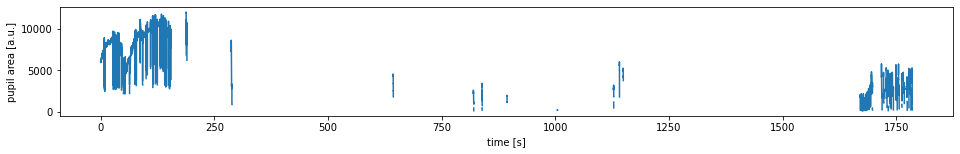

In [10]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    et_dwi.recording["eye1_pupil_size"].values,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]");

We can zoom in into the early moments of the run:

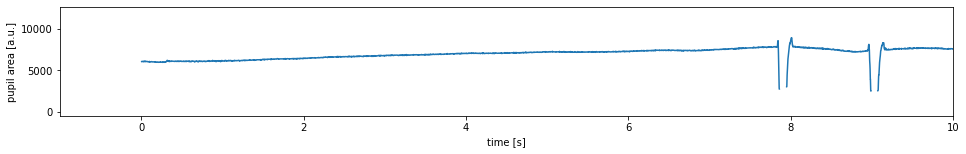

In [11]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    et_dwi.recording["eye1_pupil_size"].values,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]")
plt.xlim((-1.0, 10.0));

Next, we look at eye blinks.
The two discontinuities at almost seconds 8 and 9 of the pupil area plot could be related to blinks.

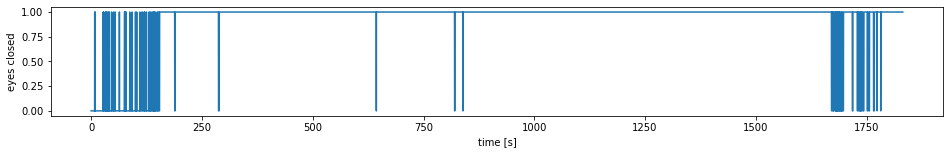

In [12]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    et_dwi.recording["eye1_blink"].values,
)

plt.xlabel("time [s]")
plt.ylabel("eyes closed");

Looks like the eyes (or at least the right eye, which was tracked) were closed during most of the run.
Let's now plot together the first ten seconds of pupil area AND the blinks binary signal.
Indeed, the pupil area drops when blinks are happening.

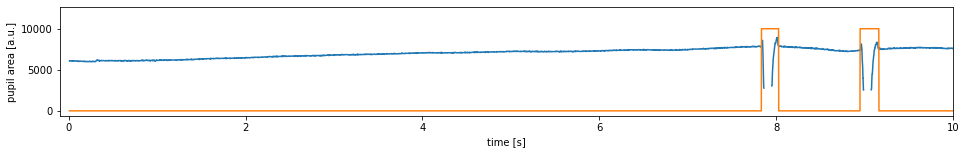

In [13]:
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis,
    et_dwi.recording["eye1_pupil_size"].values,
)

plt.plot(
    t_axis,
    et_dwi.recording["eye1_blink"].values * 10000,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]");
plt.xlim((-0.1, 10.0));

We can clean up the pupil area time series by removing data while the eye was closed.
The signal seems to display less artifacts.

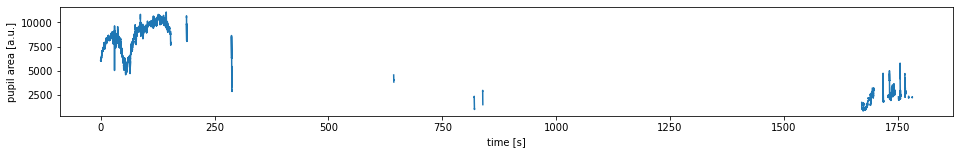

In [14]:
pupil_area = et_dwi.recording["eye1_pupil_size"].values
pupil_area[et_dwi.recording["eye1_blink"] > 0] = np.nan

fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis,
    et_dwi.recording["eye1_pupil_size"].values,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]");

We can also see the map of time spent on areas of the screen:

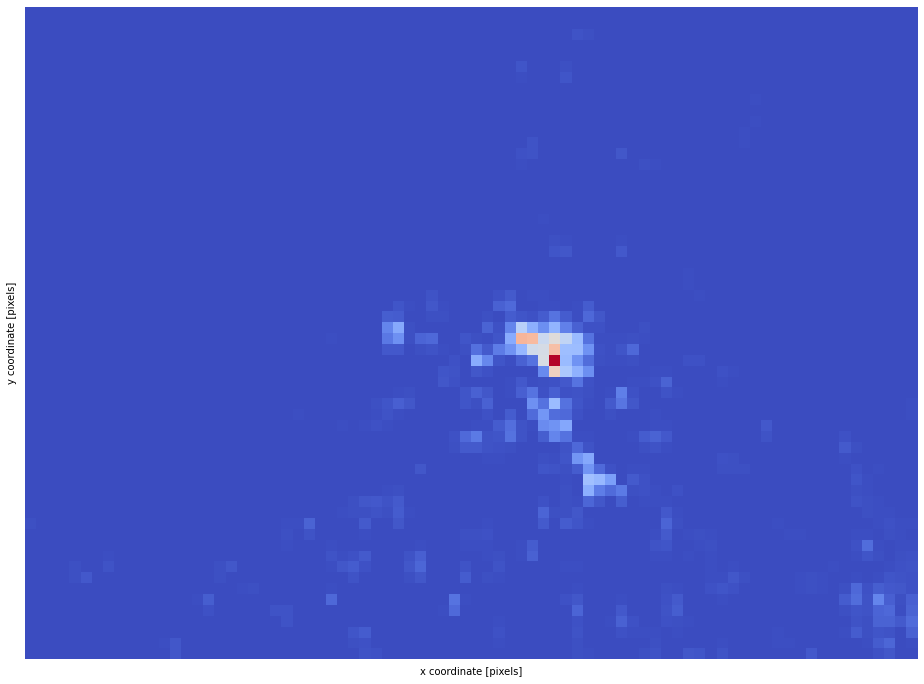

In [15]:
reload(plot)
plot.plot_heatmap_coordinate(et_dwi, density=False);

# Quality Control task (qct)

Now, let's repeat the process for the quality control task. We'll encapsulate the session data and showcase the same visualizations.

In [16]:
et_qct = et.EyeTrackingRun.from_edf(
    DATA_PATH / et_session.qct_edf.values[0],
    message_first_trigger='hello qct',
    message_last_trigger='bye qct',
)
t_axis = (et_qct.recording.timestamp.values - et_qct.metadata["StartTime"]) / et_qct.metadata["SamplingFrequency"]

First, let's look at the pupil size after filtering out blinks:

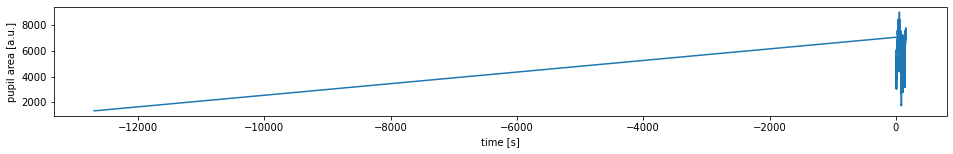

In [17]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis[et_qct.recording.eye1_blink == 0],
    et_qct.recording.loc[et_qct.recording.eye1_blink == 0, "eye1_pupil_size"].values,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]");

# OE: HERE I STOPPED

In [ ]:
QctSession4.plot_delta()

In [ ]:
QctSession4.plot_coordinates_ts()

In [ ]:
QctSession4.plot_heatmap_coordinate_density()

And now, we save both the data and the corresponding JSON file.

In [ ]:
QctSession4.save_and_process_samples(BIDS_PATH,include_events=True)

In [ ]:
QctSession4.create_info_json(BIDS_PATH,"info_ET.json")

# rest

Similarly, we'll visualize and process the data from the resting state.

In [ ]:
samples, events, messages = edf.pread(str(DATA_PATH / et_session.rest_edf.values[0]), trial_marker=b"")
RestSession4 = EyeTrackingRun(
    session=session,
    task_name='rest',
    participant=participant,
    samples=samples,
    events=events,
    messages=messages,
    message_first_trigger='start movie',
    screen_resolution=screen_resolution,
    pe=pe
)

In [ ]:
RestSession4.plot_pupil_size()

In [ ]:
RestSession4.plot_delta()

In [ ]:
RestSession4.plot_coordinates_ts()

The upcoming plot might take some time due to the substantial data size in the resting state. For a quicker overview, you can run the next cell, which provides a 2D histogram instead of the density plot.

In [ ]:
RestSession4.plot_heatmap_coordinate_density()

In [ ]:
RestSession4.plot_heatmap_coordinate_histo()

Let's save both the data and metadata.

In [ ]:
RestSession4.save_and_process_samples(BIDS_PATH,include_events=True)

In [ ]:
RestSession4.create_info_json(BIDS_PATH,"info_ET.json")

# bht

Lastly, let's handle the data from the breath-holding task.

In [ ]:
samples, events, messages = edf.pread(str(DATA_PATH / et_session.bht_edf.values[0]), trial_marker=b"")
BhtSession4 = EyeTrackingRun(
    session=session,
    task_name='bht',
    participant=participant,
    samples=samples,
    events=events,
    messages=messages,
    message_first_trigger='Hello',
    screen_resolution=screen_resolution,
    pe=pe
)

In [ ]:
BhtSession4.plot_pupil_size()

In [ ]:
BhtSession4.plot_delta()

In [ ]:
BhtSession4.plot_coordinates_ts()

In [ ]:
BhtSession4.plot_heatmap_coordinate_density()

Let's save both the data and metadata.

In [ ]:
BhtSession4.save_and_process_samples(BIDS_PATH,include_events=True)

In [ ]:
BhtSession4.create_info_json(BIDS_PATH,"info_ET.json")